<a href="https://colab.research.google.com/github/birajaghoshal/OCT_Fluid_Segmentation/blob/main/Multi_Class_Segmentation_OCT_V2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Segmentation goal:** To take either a RGB color image (heightxwidthx3) or a grayscale image (heightxwidthx1) and output a segmentation map where each pixel contains a class label.

**Background:** Optical coherence tomography (OCT) is one of the most commonly used ophthalmic diagnostic techniques. Macular Edema (ME) is the swelling of the macular region in the eye. Segmentation of the fluid region in the retinal layer is an important step in detecting lesions. However, manual segmentation is often a time consuming and subjective process. 

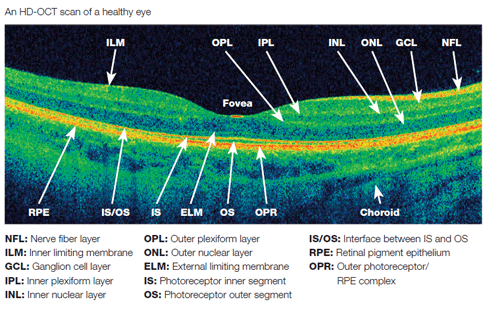

**Our goal:** Automatic fluid segmentation in retinal optical coherence tomography images (OCT). This work presents a automated method based on deep learning algorithms and convolutional neural network (CNN) to segment and detect two types of fluid including sub-retinal fluid (SRF) and intra-retinal fluid (IRF).

**Important points to note:** The important property of IRF and SRF is that these fluid types stem from abnormal blood vessels leakage from the choroidal and retinal vasculature, and the resultant dark region and IRF and SRF are located between inner limiting membrane (ILM) and retinal pigment epithelium (RPE) layers.

**Ideal Methodology:**
Step 1. The segmentation of ILM and RPE layers as a ROI for IRF and SRF regions. This step is very important due (i) the background region is very similar to fluid/cyst regions in both brightness and texture. This can easily mislead the CNN segmentation method since this method is based on
brightness of neighboring pixels of target pixel and (ii) ROI segmentation is speeding up since the ROI is processed instead of the whole image. [Alternatively we can use get_random_snippets function for patch based input to CNN]

Step 2. IRF and SRF segmentation are modeled as a supervised classification task in which fluid IRF and SRF are labeled as 0 and 1, respectively. Therefore, a CNN is trained for multi-Class classification. Note: IPF and SRF fluid types are classified as different fluid type otherwise we can consider binary classification (fluid vs tissue pixels).

Step 3. The regions between these layers are input to a convolutional neural network (CNN). CNN training can be modifired by using Transfer learning, by various types of NN architecture (UNet, UNet++, DeepVLab, DoUNet, ADC-Net etc.), image generator keras, and different loss fuctons etc.

Final Solution: Foreground Segmentation using FCN + Edge Detection Using HED + Object Detection Using Faster R-CNN

In [1]:
path = ""
from google.colab import drive, files
#from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import skimage.restoration as sr
import numpy as np
import glob
import h5py
import os
import scipy.io as scio
from skimage import exposure
from skimage.io import imsave, imread
#from scipy.misc import imresize
#from medpy.filter.noise import immerkaer
from scipy.io import savemat
from scipy import ndimage, misc
import matplotlib.pyplot as plt
%matplotlib inline
import re
from keras.preprocessing import image
import pylab
%matplotlib inline
import skimage.io as sio
import skimage
from skimage.morphology import disk, rectangle, closing, opening, binary_closing, convex_hull_image
from skimage.filters.rank import entropy
from PIL import Image
from PIL import ImageFilter

import os
from keras.preprocessing import image
import pylab
import tensorflow as tf
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
import pandas as pd
from datetime import datetime 

from sklearn.metrics import f1_score, roc_auc_score
from keras.preprocessing import image
import pylab
import numpy as np
import numpy.ma as ma

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import initializers
from keras.layers import SpatialDropout2D,Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,AveragePooling2D, UpSampling2D, BatchNormalization, Activation, add,Dropout,Permute,ZeroPadding2D,Add, Reshape
from keras.models import Model, model_from_json
#from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU, ReLU, PReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import applications, optimizers, callbacks
import matplotlib
import keras
import tensorflow as tf
from keras.layers import *

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import initializers
from keras.layers import SpatialDropout2D,Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,AveragePooling2D, UpSampling2D, BatchNormalization, Activation, add,Dropout,Permute,ZeroPadding2D,Add, Reshape
from keras.models import Model, model_from_json
#from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU, ReLU, PReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import applications, optimizers, callbacks
import matplotlib
import keras
import tensorflow as tf
from keras.layers import *
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

%matplotlib inline



In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1 # grayscale images
classes = 2
lr = 1e-4

In [4]:
# paths to image folders 
oct_images_path='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/oct'
irf_masks_path='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/irf/'
srf_masks_path='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/srf/'


In [5]:
oct_images = sorted(
    [
        os.path.join(oct_images_path, fname)
        for fname in os.listdir(oct_images_path)
        if fname.endswith(".png")
    ]
)

irf_masks_img = sorted(
    [
        os.path.join(irf_masks_path, fname)
        for fname in os.listdir(irf_masks_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

srf_masks_img = sorted(
    [
        os.path.join(srf_masks_path, fname)
        for fname in os.listdir(srf_masks_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of OCT samples:", len(oct_images))
print("Number of IRF samples:", len(irf_masks_img))
print("Number of SRF samples:", len(srf_masks_img))


Number of OCT samples: 167
Number of IRF samples: 167
Number of SRF samples: 167


In [6]:
'''
def create_roi_masks(tresh=1e-2):
    import skimage.io as sio
    import skimage
    from skimage.morphology import disk, rectangle, closing, opening, binary_closing, convex_hull_image
    from skimage.filters.rank import entropy
    from PIL import Image
    from PIL import ImageFilter

    DATA_ROOT ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/'
    MASK_PATH_IRF ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/processed/masks/'

    #print (DATA_ROOT)
    image_names = list()
    for subdir, dirs, files in os.walk(DATA_ROOT + 'oct'):
        for file in files:
            #print(file)
            filepath = subdir + os.sep + file
            print("file", filepath)
            if filepath.endswith(".png"):
                image_name = filepath.split('/')[-1]
                image_names.append([filepath, image_name])
                #print(image_name)

    for filepath, image_name in image_names:
        # print filepath, image_name
        img = sio.imread(filepath)
        im_mask = sio.imread(MASK_PATH_IRF + image_name)
        im_mask = im_mask.astype(np.int8)
        im_slice = skimage.img_as_float(img.astype(np.float32) / 128. - 1.)

        im_slice_ = entropy(im_slice, disk(15))
        im_slice_ = im_slice_ / (np.max(im_slice_) + 1e-16)
        im_slice_ = np.asarray(im_slice_ > tresh, dtype=np.int8)
        im_slice_ = np.bitwise_or(im_slice_,im_mask)
        selem = disk(55)
        im_slice_ = binary_closing(im_slice_, selem=selem)

        h, w = im_slice_.shape
        rnge = list()
        for x in range(0, w):
            col = im_slice_[:, x]
            col = np.nonzero(col)[0]
            # print col, col.shape
            if len(col) > 0:
                y_min = np.min(col)
                y_max = np.max(col)
                rnge.append(int((float(y_max) - y_min)/h*100.))
                im_slice_[y_min:y_max, x] = 1
        if len(rnge) > 0:
            print (image_name, np.max(rnge))
        else:
            print (image_name, "**************")

        plt.imshow(im_slice, cmap='gray')
        #plt.imshow(im_slice_, cmap='jet', alpha=0.5)
        plt.pause(.1)

        #im_slice_ = Image.fromarray((im_slice_ * 255).astype('uint8'), mode='L')
        im_slice_ = Image.fromarray(im_slice_, mode='L')
        save_name = DATA_ROOT + 'processed/roi_oct/' + image_name
        im_slice_.save(save_name)
'''
#create_roi_masks(tresh=1e-2)

'\ndef create_roi_masks(tresh=1e-2):\n    import skimage.io as sio\n    import skimage\n    from skimage.morphology import disk, rectangle, closing, opening, binary_closing, convex_hull_image\n    from skimage.filters.rank import entropy\n    from PIL import Image\n    from PIL import ImageFilter\n\n    DATA_ROOT =\'/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/\'\n    MASK_PATH_IRF =\'/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/processed/masks/\'\n\n    #print (DATA_ROOT)\n    image_names = list()\n    for subdir, dirs, files in os.walk(DATA_ROOT + \'oct\'):\n        for file in files:\n            #print(file)\n            filepath = subdir + os.sep + file\n            print("file", filepath)\n            if filepath.endswith(".png"):\n                image_name = filepath.split(\'/\')[-1]\n                image_names.append([filepath, image_name])\n                #print(image_name)\n\n    for filepath, image_

In [7]:
'''
def combine_masks(tresh=1e-2):
    import skimage.io as sio
    import skimage
    from skimage.morphology import disk, rectangle, closing, opening, binary_closing, convex_hull_image
    from skimage.filters.rank import entropy
    from PIL import Image
    from PIL import ImageFilter

    MASK_PATH_SRF ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/'
    MASK_PATH_IRF ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/irf/'

    #print (DATA_ROOT)
    image_names = list()
    for subdir, dirs, files in os.walk(MASK_PATH_SRF + 'srf'):
        for file in files:
            #print(file)
            filepath = subdir + os.sep + file
            print("file", filepath)
            if filepath.endswith(".png"):
                image_name = filepath.split('/')[-1]
                image_names.append([filepath, image_name])
                print(image_name)

    for filepath, image_name in image_names:
        # print filepath, image_name
        im_mask_srf = sio.imread(filepath)
        im_mask_irf = sio.imread(MASK_PATH_IRF + image_name)
        # add masks
        result = 255*(im_mask_srf + im_mask_irf)
        result = result.clip(0, 255).astype("uint8")

        plt.imshow(result, cmap='gray')
        plt.pause(.1)

        mask_slice_ = Image.fromarray((result * 255).astype('uint8'), mode='L')
        save_name = '/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/processed/masks/' + image_name
        mask_slice_.save(save_name)
'''
#combine_masks(tresh=1e-2)

'\ndef combine_masks(tresh=1e-2):\n    import skimage.io as sio\n    import skimage\n    from skimage.morphology import disk, rectangle, closing, opening, binary_closing, convex_hull_image\n    from skimage.filters.rank import entropy\n    from PIL import Image\n    from PIL import ImageFilter\n\n    MASK_PATH_SRF =\'/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/\'\n    MASK_PATH_IRF =\'/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/irf/\'\n\n    #print (DATA_ROOT)\n    image_names = list()\n    for subdir, dirs, files in os.walk(MASK_PATH_SRF + \'srf\'):\n        for file in files:\n            #print(file)\n            filepath = subdir + os.sep + file\n            print("file", filepath)\n            if filepath.endswith(".png"):\n                image_name = filepath.split(\'/\')[-1]\n                image_names.append([filepath, image_name])\n                print(image_name)\n\n    for filepath, image_name in 

In [8]:
# Load the list of OCT images, then initialize the images

X = np.zeros((len(oct_images_path), IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.float32)

#OCT_PATH_Processed ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/processed/'
#OCT_PATH ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/'

image_names = list()
for subdir, dirs, files in os.walk(oct_images_path): #(OCT_PATH + 'oct'):
    for file in files:
        #print(file)
        filepath = subdir + os.sep + file
        #print("file", filepath)
        if filepath.endswith(".png"):
            image_name = filepath.split('/')[-1]
            image_names.append([filepath, image_name])
            #print(image_name)

X = list()
for filepath, image_name in image_names:
# convert the data and labels to NumPy arrays while scaling the pixel intensities to the range [0, 255]
    img = image.load_img(filepath, grayscale=False,target_size=(IMG_WIDTH, IMG_HEIGHT)) #imread(img_path)[:,:,:3] #.astype("float32") #/ 255.0 -> is done by rgb2gray
    img = image.img_to_array(img)
    img = img.astype('float32') / 255.0
    X.append(img)    
   
X = np.array(X)


In [9]:

Y_irf = np.zeros((len(irf_masks_img), IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.uint8)
Y_srf = np.zeros((len(srf_masks_img), IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.uint8)
Y = np.zeros((len(oct_images), IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.uint8)

for i in range(len(oct_images)):
        
    irf_mask_path = irf_masks_img[i]
    irf_mask = image.load_img(irf_mask_path, grayscale=True,target_size=(IMG_WIDTH, IMG_HEIGHT)) #imread(img_path)[:,:,:3] #.astype("float32") #/ 255.0 -> is done by rgb2gray
    irf_mask = image.img_to_array(irf_mask)   
    Y_irf[i] = irf_mask

    srf_mask_path = srf_masks_img[i]
    srf_mask = image.load_img(srf_mask_path, grayscale=True,target_size=(IMG_WIDTH, IMG_HEIGHT)) #imread(img_path)[:,:,:3] #.astype("float32") #/ 255.0 -> is done by rgb2gray
    srf_mask = image.img_to_array(srf_mask)    
    Y_srf[i] = srf_mask

#mask = np.ma.mask_or(Y_irf, Y_srf, copy=False, shrink=True) 
#mask = np.stack([Y_irf, Y_srf], axis=-1)
Y = np.concatenate((Y_irf, Y_srf), axis=3)
print(Y_irf.shape, Y_srf.shape)
print(Y.shape)
#Y=mask.reshape(mask.shape[0],mask.shape[1],mask.shape[2],mask.shape[4])
#print(Y.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(167, 256, 256, 1) (167, 256, 256, 1)
(167, 256, 256, 2)


In [10]:
#We would need a channel for each IPF and SPF. We can read the masks as numpy arrays and concatenate them along the channels axis
#Effectively to create a single numpy array of shape (width, height, 2).

#Segmentation network should also output a mask of shape (width, height, 2) with activation function as softmax for the last layer 
#in case of Multi-Class segmentation

#We can experiment with various loss functions instead of cross entropy. For multi-class segmentation, we can try:
#generalized dice loss
#dice loss (summed across all classes)
#categorical focal loss
#boundary loss

# We can try with multiple networks e.g.: ReLayNet, DeepLabv3, SegNet etc.

#Alternateive we can use Multi-Label Classifition (this is more practical)


In [11]:
X = X.astype('float32')
Y = Y.astype('float32')

print(X.shape)
print(Y.shape)

(167, 256, 256, 3)
(167, 256, 256, 2)


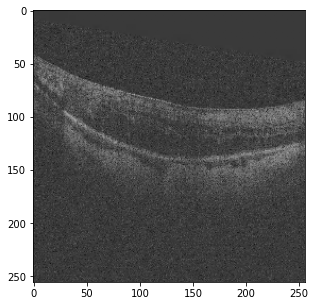

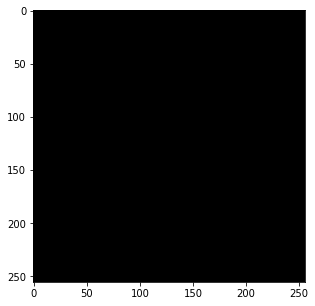

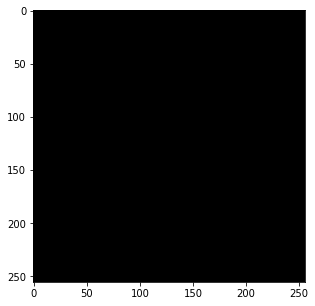

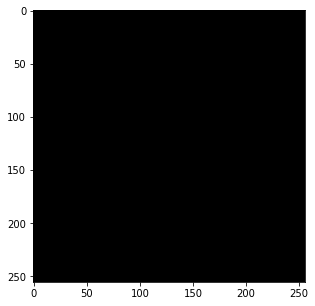

In [30]:
from google.colab.patches import cv2_imshow

i = 0

from matplotlib import pyplot as plt
plt.imshow(X[i], cmap='gray')
plt.show()

plt.imshow(Y[i,:,:,0], cmap='gray')
plt.show()

plt.imshow(Y_irf[i,:,:,0], cmap='gray')
plt.show()

plt.imshow(Y_srf[i,:,:,0], cmap='gray')
plt.show()


In [13]:
train_test_split = int(len(X)*0.8)
x_train = X[:train_test_split]
y_train = Y[:train_test_split]
x_test = X[train_test_split:]
y_test = Y[train_test_split:]

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(133, 256, 256, 3)
(133, 256, 256, 2)
(34, 256, 256, 3)
(34, 256, 256, 2)


In [15]:
def random_snippet(x, y, size=(64,64), rotate=True, flip=True):
    '''sample snippets from images. return image tuple (real, segmentation) of size `size` '''
    
    assert x.shape[:2] == y.shape[:2]
    
    # get image sample
    sample = np.random.randint(0, x.shape[0])
    # get x and y dimensions
    min_h = np.random.randint(0, x.shape[1]-size[0])
    max_h = min_h+size[0]
    min_w = np.random.randint(0, x.shape[2]-size[1])
    max_w = min_w+size[1]
    # extract snippet
    im_x = x[sample, min_h:max_h, min_w:max_w, :]
    im_y = y[sample, min_h:max_h, min_w:max_w, :]
    
    # rotate
    if rotate:
        k = np.random.randint(0,4)
        im_x = np.rot90(im_x, k=k, axes=(0,1))
        im_y = np.rot90(im_y, k=k, axes=(0,1))
        
    # flip left-right, up-down
    if flip:
        if np.random.random() < 0.5:
            lr_ud = np.random.randint(0,2) # flip up-down or left-right?
            im_x = np.flip(im_x, axis=lr_ud)
            im_y = np.flip(im_y, axis=lr_ud)          
    
    return (im_x, im_y)

def get_random_snippets(x, y, number, size):
    snippets = [random_snippet(x, y, size) for i in range(number) ]
     
    ims_x = np.array([i[0] for i in snippets])
    ims_y = np.array([i[1] for i in snippets])
    return (ims_x, ims_y)

In [16]:
#X_train, Y_train = get_random_snippets(x_train, y_train, number=1000, size=(64,64))
#X_test, Y_test = get_random_snippets(x_test, y_test, number=100, size=(64,64))
X_train, Y_train, X_test, Y_test = x_train, y_train, x_test, y_test

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (133, 256, 256, 3)
Y_train shape:  (133, 256, 256, 2)
X_test shape:  (34, 256, 256, 3)
Y_test shape:  (34, 256, 256, 2)


<Figure size 1440x1440 with 0 Axes>

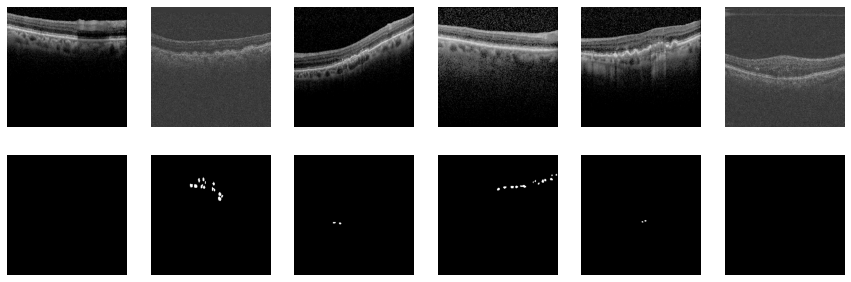

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]
M=6
list_index = np.random.randint(low=0, high=X_train.shape[0], size=M)
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(2,M)
for k, ind in enumerate(list_index):
    ax[0,k].imshow(X_train[ind])
    ax[1,k].imshow(Y_train[ind,:,:,0], cmap='gray')
    
    ax[0,k].axis('off')
    ax[1,k].axis('off')


In [18]:
from keras import backend as K

# different loss functions
def dice_coef(y_true, y_pred):
    smooth = 1.0  #0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def universal_dice_coef_multilabel(numLabels):
    def dice_coef_multilabel(y_true, y_pred):
        dice=0
        for index in range(numLabels):
            dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        return dice/numLabels # taking average
    return dice_coef_multilabel

def universal_dice_coef_loss(numLabels):
    def dice_coef_loss_multilabel(y_true, y_pred):
        dice=0
        for index in range(numLabels):
            dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        return 1 - dice/numLabels # taking average
    return dice_coef_loss_multilabel

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

def iou_loss(y_true,y_pred):
    return 1 - jacard(y_true, y_pred)

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.75
    smooth = 1
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)
def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [19]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def UNET(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(x8)

    return Model(inputs, output)

#model = UNET((256, 256, 3), 2)
#model.summary()
# multiclass segmentation with non overlapping class masks (our classes + background): activation='softmax'
# multiclass segmentation with independent overlapping/non-overlapping class masks: activation='sigmoid'

In [20]:
num_class = 2
model = UNET((256, 256, 3), 2)

#model.compile(optimizer='adam', loss=focal_tversky, metrics=[dice_coef, jacard, tversky, focal_tversky, 'acc'])

model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=[universal_dice_coef_loss(num_class)],
                  metrics=[universal_dice_coef_multilabel(num_class)])


In [21]:

tf.config.run_functions_eagerly(True)

batch_size = 32
epochs = 200

train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

callbacks = [
    ModelCheckpoint("/content/drive/My Drive/App/MoorfieldsInnovationLab/target/UNET_Model.h5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10, verbose=1)
]

history = model.fit(X_train, Y_train,
    steps_per_epoch=train_steps,
    validation_split=0.2,
    epochs=epochs,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/200
4/4 [==============================] - ETA: 0s - loss: 0.6607 - dice_coef_multilabel: 0.3381
Epoch 1: saving model to /content/drive/My Drive/App/MoorfieldsInnovationLab/target/UNET_Model.h5
4/4 [==============================] - 21s 2s/step - loss: 0.6607 - dice_coef_multilabel: 0.3381 - val_loss: 0.7874 - val_dice_coef_multilabel: 0.2126 - lr: 1.0000e-04
Epoch 2/200
4/4 [==============================] - ETA: 0s - loss: 0.6137 - dice_coef_multilabel: 0.3866
Epoch 2: saving model to /content/drive/My Drive/App/MoorfieldsInnovationLab/target/UNET_Model.h5
4/4 [==============================] - 2s 502ms/step - loss: 0.6137 - dice_coef_multilabel: 0.3866 - val_loss: 0.7873 - val_dice_coef_multilabel: 0.2127 - lr: 1.0000e-04
Epoch 3/200
4/4 [==============================] - ETA: 0s - loss: 0.6039 - dice_coef_multilabel: 0.4005
Epoch 3: saving model to /content/drive/My Drive/App/MoorfieldsInnovationLab/target/UNET_Model.h5
4/4 [==============================] - 2s 517ms/step 

test_img (256, 256, 3)
ground_truth (256, 256, 2)
ground_truth (256, 1, 256, 2)
test_img_input (1, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


test_i (256, 256, 2)
Y_train (133, 256, 256, 2)


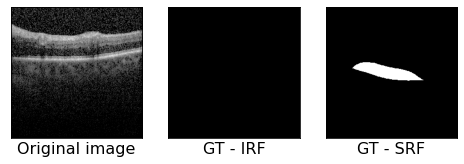

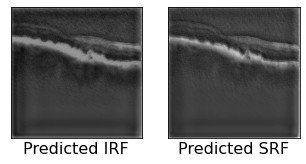

In [22]:
# If you load with batchsize 40 in valid generator, the max index will be 39 (Smaller Dataset)

# Run inference on Validation data
img_index = 14 #112 #14 #random.randint(0, len(X_train))
test_img = X_test[img_index] #X_train[img_index]
print("test_img",test_img.shape)
ground_truth=Y_train[img_index]
print("ground_truth",ground_truth.shape)
ground_truth = np.expand_dims(ground_truth, axis=1)
print("ground_truth",ground_truth.shape)

test_img_input=np.expand_dims(test_img, 0)
print("test_img_input",test_img_input.shape)

test_i = model.predict(test_img_input)
test_i = test_i.reshape((256, 256, 2))
print("test_i",test_i.shape)
print("Y_train",Y_train.shape)

img_list1 = [X_train[img_index , :, :, :3], Y_train[img_index , :, :, 0], Y_train[img_index , :, :, 1] ]
label_list1 = ['Original image', 'GT - IRF', 'GT - SRF']
plt.figure(figsize=(8, 8))
ctr = 0

for i in img_list1:
  ctr +=1
  plt.subplot(1,3,ctr)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(label_list1[ctr-1], fontsize=16)
  plt.imshow(i, cmap='gray')

img_list2 = [ test_i[:, :, 0], test_i[:, :, 1]]

label_list2 = ['Predicted IRF', 'Predicted SRF']
plt.figure(figsize=(8, 8))
ctr = 0

for i in img_list2:
  ctr +=1
  plt.subplot(1,3,ctr)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(label_list2[ctr-1], fontsize=16)
  plt.imshow(i, cmap="gray")


---Image: -- 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


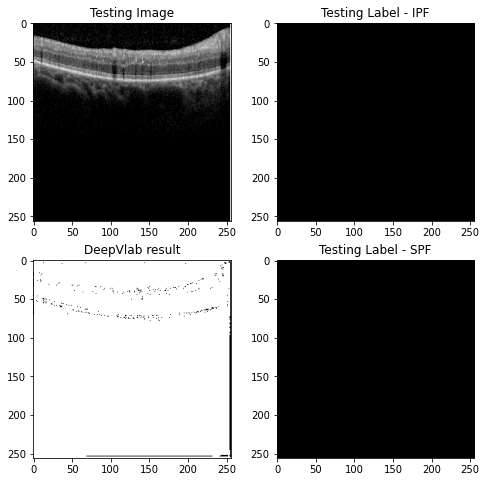

------
---Image: -- 1


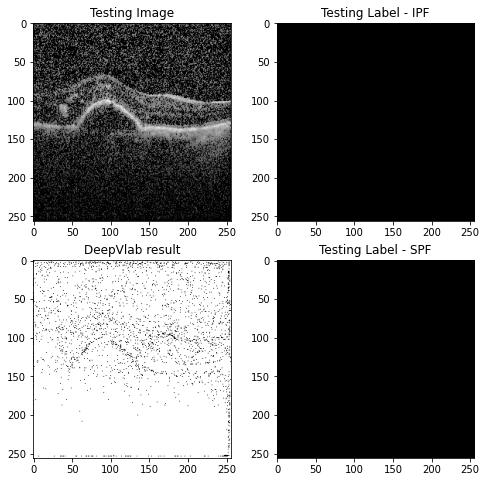

------
---Image: -- 2


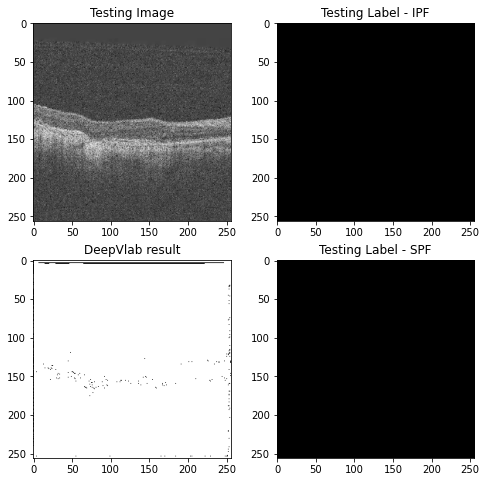

------
---Image: -- 3


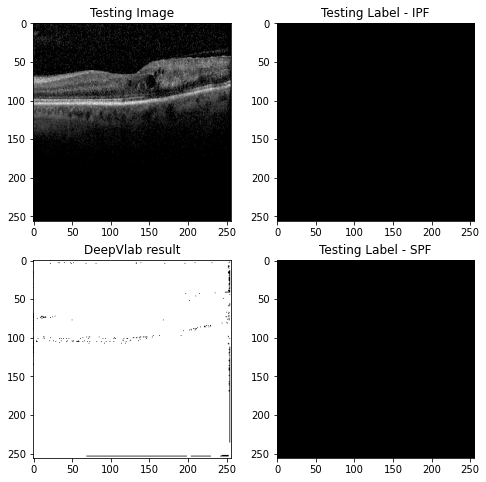

------
---Image: -- 4


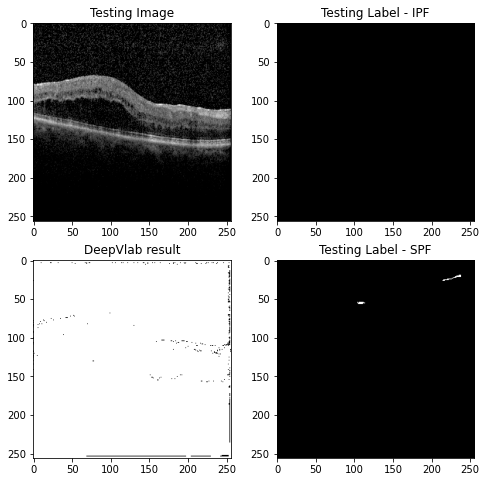

------


In [23]:
for i  in range (5) : #(X_test.shape[0]):
    print ("---Image: --", i)
    test_img = X_test[i]
    ground_truth=Y_test[i]
    test_img_input=np.expand_dims(test_img, 0)
    test_pred_unet = model.predict(test_img_input) 
    test_prediction_unet = np.argmax(test_pred_unet, axis=3)[0,:,:]

    plt.figure(figsize=(8, 8))
    plt.subplot(221)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(222)
    plt.title('Testing Label - IPF')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(223)
    plt.title('DeepVlab result')
    plt.imshow(test_prediction_unet, cmap='gray')
    plt.subplot(224)
    plt.title('Testing Label - SPF')
    plt.imshow(ground_truth[:,:,1], cmap='gray')
    plt.show()
    print ("------")
    plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


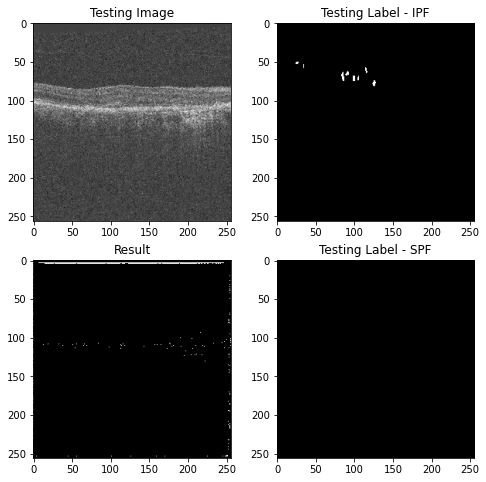

In [24]:
from keras import models
#model = keras.models.load_model("/content/drive/My Drive/App/MoorfieldsInnovationLab/target/model.h5")
##############################################################
import random
test_img_number = 112 #112 #114 #random.randint(0, len(X_train))
test_img = X_train[test_img_number]
ground_truth=Y_train[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_pred_unet = model.predict(test_img_input) 

test_prediction_unet = np.argmax(test_pred_unet, axis=3)[0,:,:]

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(222)
plt.title('Testing Label - IPF')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(223)
plt.title('Result')
plt.imshow(1-test_prediction_unet, cmap='gray')
plt.subplot(224)
plt.title('Testing Label - SPF')
plt.imshow(ground_truth[:,:,1], cmap='gray')

plt.show()

In [25]:
break;

SyntaxError: ignored